### **1. tf_flowers 데이터셋**

In [21]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from functools import partial
import tensorflow_datasets as tfds
from keras.optimizers import SGD, Adam
import time

Flower dataset 불러온 후 test set(10%), valid set(15%), train set(75%)으로 나눈다.

In [35]:
# 데이터를 test, validation, train data로 나눈다.
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes # 5
dataset_size = info.splits["train"].num_examples # 3670

test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

Data Augmentation을 적용 후 전처리

In [30]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 20
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

Data Augmentation 미적용 후 전처리

In [36]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 20
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

EarlyStopping / Checkpoint 생성

In [31]:
# 콜백 함수(체크포인트 / 얼리 스타핑) 생성
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="model_flower.h5",
        monitor="val_loss",
        save_best_only=True,
    )
]

모델 정의

In [37]:
inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 5, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 5, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x) # 원래 모델에서는 Dense층 이전에 Flatten 층을 사용
x = layers.Dropout(0.3)(x) # 규제를 위한 드롭아웃 층
outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [38]:
model.compile(loss="sparse_categorical_crossentropy",
              #optimizer="rmsprop",
              optimizer = Adam(),
              #optimizer = SGD(learning_rate = 0.05, momentum = 0.9, decay = 0.001),
              metrics=["sparse_categorical_accuracy"],)
history = model.fit(
    train_set,
    epochs=100,
    steps_per_epoch=86,
    validation_data=valid_set,
    validation_steps=len(valid_set),
    callbacks=callbacks_list)

Epoch 1/100
86/86 [==============================] - 21s 185ms/step - loss: 1.3197 - sparse_categorical_accuracy: 0.4657 - val_loss: 1.6078 - val_sparse_categorical_accuracy: 0.2377
Epoch 2/100
86/86 [==============================] - 16s 181ms/step - loss: 1.1252 - sparse_categorical_accuracy: 0.5599 - val_loss: 1.6491 - val_sparse_categorical_accuracy: 0.2377
Epoch 3/100
86/86 [==============================] - 15s 178ms/step - loss: 1.0288 - sparse_categorical_accuracy: 0.6198 - val_loss: 2.2786 - val_sparse_categorical_accuracy: 0.2377
Epoch 4/100
86/86 [==============================] - 15s 176ms/step - loss: 0.9202 - sparse_categorical_accuracy: 0.6419 - val_loss: 2.3387 - val_sparse_categorical_accuracy: 0.2377
Epoch 5/100
86/86 [==============================] - 16s 181ms/step - loss: 0.9548 - sparse_categorical_accuracy: 0.6273 - val_loss: 2.1921 - val_sparse_categorical_accuracy: 0.2377
Epoch 6/100
86/86 [==============================] - 15s 176ms/step - loss: 0.8917 - spars

In [39]:
print("Test\n")
test_model = tf.keras.models.load_model("model_flower.h5")

print("Evaluate")
test_loss, test_acc = test_model.evaluate(test_set)

print("Predict")
start_time = time.time()
predictions = test_model.predict(test_set)
end_time = time.time()
prediction_time = end_time - start_time
print("-------------------------------------------------------")
print("Test result\n")
print(f"Test loss: {test_loss:.3f}")
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test Prediction time: {prediction_time:.3f} seconds")
print("")

Test

Evaluate
19/19 [==============================] - 1s 44ms/step - loss: 0.4795 - sparse_categorical_accuracy: 0.8202
Predict
19/19 [==============================] - 1s 35ms/step
-------------------------------------------------------
Test result

Test loss: 0.480
Test accuracy: 0.820
Test Prediction time: 0.932 seconds



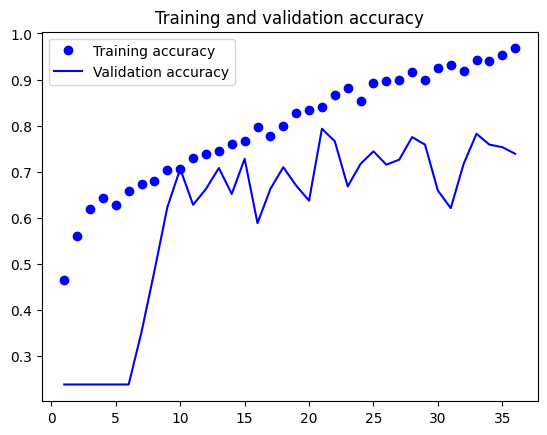

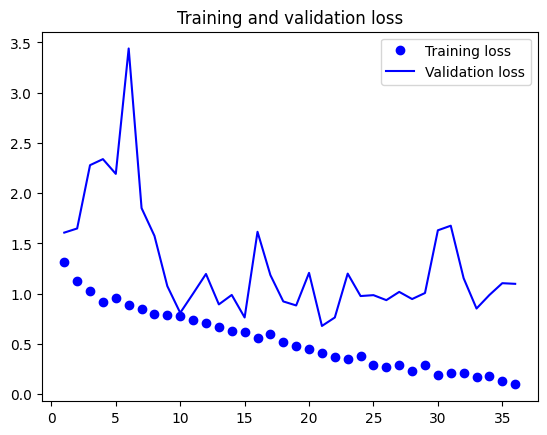

In [40]:
accuracy = history.history["sparse_categorical_accuracy"]
val_accuracy = history.history["val_sparse_categorical_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### **2. citrus_leaves 데이터셋**

In [84]:
# 데이터를 test, validation, train data로 나눈다.
dataset, info = tfds.load("citrus_leaves", as_supervised=True, with_info=True)
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples

test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "citrus_leaves",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)


Data Augmentation 적용

In [79]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 20
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

Data Augmentation 미적용

In [85]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 20
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [66]:
# 콜백 함수(체크포인트 / 얼리 스타핑) 생성
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="model_citrus.h5",
        monitor="val_loss",
        save_best_only=True,
    )
]

In [86]:
inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 5, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 5, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [87]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Adam(),
              metrics=["sparse_categorical_accuracy"])
history = model.fit(
    train_set,
    epochs=100,
    steps_per_epoch=50,
    validation_data=valid_set,
    validation_steps=len(valid_set),
    callbacks=callbacks_list)

Epoch 1/100
50/50 [==============================] - 11s 179ms/step - loss: 0.7392 - sparse_categorical_accuracy: 0.6580 - val_loss: 1.3919 - val_sparse_categorical_accuracy: 0.3034
Epoch 2/100
50/50 [==============================] - 9s 174ms/step - loss: 0.6068 - sparse_categorical_accuracy: 0.7430 - val_loss: 1.3952 - val_sparse_categorical_accuracy: 0.3483
Epoch 3/100
50/50 [==============================] - 9s 176ms/step - loss: 0.4591 - sparse_categorical_accuracy: 0.8300 - val_loss: 1.6214 - val_sparse_categorical_accuracy: 0.3483
Epoch 4/100
50/50 [==============================] - 9s 175ms/step - loss: 0.3150 - sparse_categorical_accuracy: 0.8920 - val_loss: 2.2660 - val_sparse_categorical_accuracy: 0.3483
Epoch 5/100
50/50 [==============================] - 9s 173ms/step - loss: 0.3139 - sparse_categorical_accuracy: 0.8980 - val_loss: 2.4701 - val_sparse_categorical_accuracy: 0.3483
Epoch 6/100
50/50 [==============================] - 8s 169ms/step - loss: 0.2644 - sparse_cat

In [88]:
print("Test\n")
test_model = tf.keras.models.load_model("model_citrus.h5")

print("Evaluate")
test_loss, test_acc = test_model.evaluate(test_set)

print("Predict")
start_time = time.time()
predictions = test_model.predict(test_set)
end_time = time.time()
prediction_time = end_time - start_time
print("-------------------------------------------------------")
print("Test result\n")
print(f"Test loss: {test_loss:.3f}")
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test Prediction time: {prediction_time:.3f} seconds")
print("")

Test

Evaluate
3/3 [==============================] - 1s 56ms/step - loss: 0.2060 - sparse_categorical_accuracy: 0.9322
Predict
3/3 [==============================] - 1s 41ms/step
-------------------------------------------------------
Test result

Test loss: 0.206
Test accuracy: 0.932
Test Prediction time: 0.900 seconds



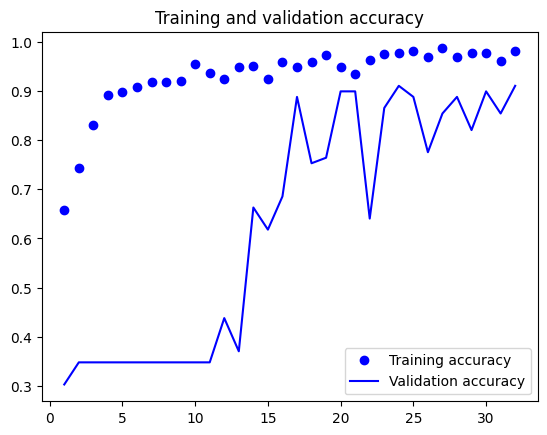

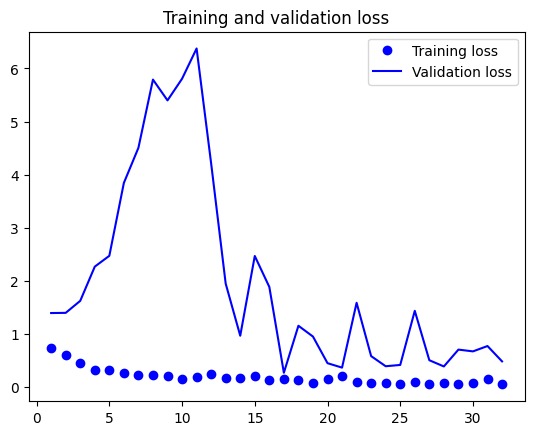

In [89]:
accuracy = history.history["sparse_categorical_accuracy"]
val_accuracy = history.history["val_sparse_categorical_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()